# To Find Out:
What constitutes low transition activity for slabs in a given milemarker? A high transition activity?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../spreadsheet_data/rate_of_damage_vs_damage.csv')
kmeans_fig = px.scatter(df, x='Percentage of NC that Transitioned to Damaged', 
                        y='Percentage of Mildly Damaged to Critically Damaged')

kmeans_fig.show()

# Outliers
Removing outliers consists of looking at each column of the two variables that will be analyzed in the k-means clustering algorithm. For each variable, a datapoint was removed if the value is less than $Q1 - 1.5IQR$ or greater than $Q3 + 1.5IQR$. Below are the distributions of the two variables I will be analyzing.

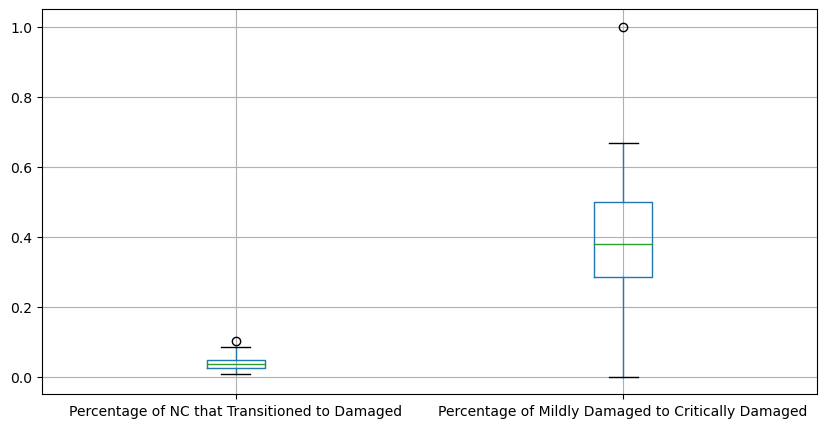

In [3]:
boxplot = df.boxplot(column=['Percentage of NC that Transitioned to Damaged', 
                             'Percentage of Mildly Damaged to Critically Damaged'], 
                     figsize=(10, 5))

0.08650000000000001
0.8210000000000001


,Unnamed: 0,Mile,Year,Percent Damaged,Percentage of NC that Transitioned to Damaged,Percentage of Mildly Damaged to Critically Damaged
0,0,22,2015,0.187,0.038,0.222
1,1,22,2016,0.218,0.027,0.368
2,2,22,2017,0.239,0.036,0.333
3,3,22,2018,0.266,0.024,0.500
4,4,21,2015,0.189,0.037,0.375


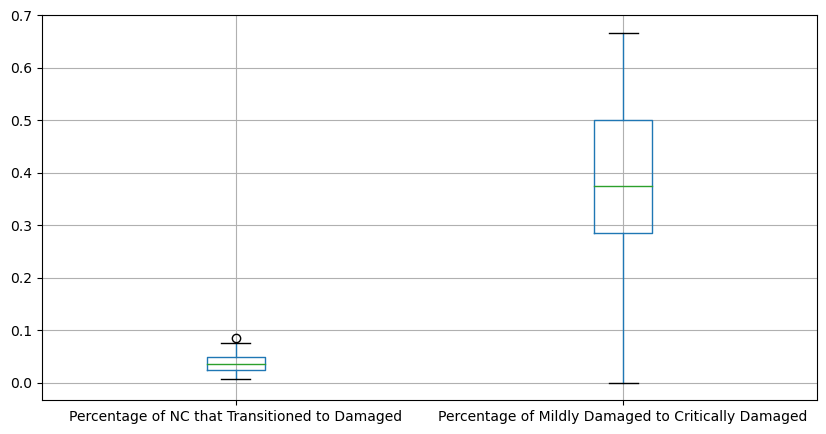

In [4]:

Q1 = df['Percentage of NC that Transitioned to Damaged'].quantile(0.25)
Q3 = df['Percentage of NC that Transitioned to Damaged'].quantile(0.75)
IQR = Q3 - Q1
print(IQR * 1.5 + Q3)
df = df[(df['Percentage of NC that Transitioned to Damaged'] >= Q1 - 1.5 * IQR) & 
        (df['Percentage of NC that Transitioned to Damaged'] <= Q3 + 1.5 * IQR)]
Q1_2 = df['Percentage of Mildly Damaged to Critically Damaged'].quantile(0.25)
Q3_2 = df['Percentage of Mildly Damaged to Critically Damaged'].quantile(0.75)
IQR_2 = Q3_2 - Q1_2
print(IQR_2 * 1.5 + Q3_2)
df = df[(df['Percentage of Mildly Damaged to Critically Damaged'] >= Q1_2 - 1.5 * IQR_2) 
        & (df['Percentage of Mildly Damaged to Critically Damaged'] <= Q3_2 + 1.5 * IQR_2)]


boxplot = df.boxplot(column=['Percentage of NC that Transitioned to Damaged', 
                             'Percentage of Mildly Damaged to Critically Damaged'], 
                     figsize=(10, 5))
df.head()

It is good practice to standardize data. The goal is for both the distributions to be close to the standard normal distribution with $\mu = 0, \sigma = 1$. For each value, a Z-score was computed. 

$z = \frac{x - \mu}{\sigma}$

In [5]:
scaler = StandardScaler()
df[['S_NC_to_damaged', 'S_mild_to_critical']] = scaler.fit_transform(
    df[['Percentage of NC that Transitioned to Damaged', 
        'Percentage of Mildly Damaged to Critically Damaged']])
df.head()


,Unnamed: 0,Mile,Year,Percent Damaged,Percentage of NC that Transitioned to Damaged,Percentage of Mildly Damaged to Critically Damaged,S_NC_to_damaged,S_mild_to_critical
0,0,22,2015,0.187,0.038,0.222,0.031920,-1.018706
1,1,22,2016,0.218,0.027,0.368,-0.548190,-0.113407
2,2,22,2017,0.239,0.036,0.333,-0.073555,-0.330431
3,3,22,2018,0.266,0.024,0.500,-0.706402,0.705082
4,4,21,2015,0.189,0.037,0.375,-0.020817,-0.070002


# Finding $k$ 
The process of finding the optimum $k$ was to run the $k$-means algorithm  9 times, where $1 \leq k \leq 9$, $k \in \mathbb{Z}$. For each $k$, the sum of the distance squared for each point to its nearest centroid (the intertia) was determined. A line plot was generated, and the $k$ was determined by finding the point where the change of inertia goes from high to low.

c:\Users\jaden\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



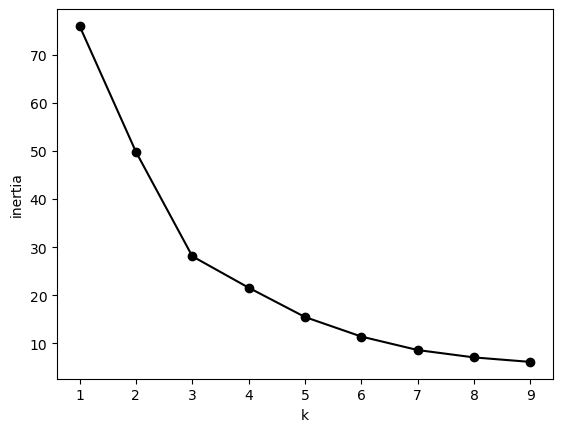

In [6]:
def find_optimum_k(df, max_k):
    means = []
    inertias = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        means.append(k)
        inertias.append(kmeans.inertia_)
    plt.plot(means, inertias, '-o', color='black')
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.show()


find_optimum_k(df[['S_NC_to_damaged', 'S_mild_to_critical']], 10)

In [7]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['S_NC_to_damaged', 'S_mild_to_critical']])
df['k_means'] = kmeans.labels_
df['id'] = 'Mile: ' + df['Mile'].astype(str) + ' Year: ' + df['Year'].astype(str)
df['k_means'] = df['k_means'].astype(str)   
df.head()


,Unnamed: 0,Mile,Year,Percent Damaged,Percentage of NC that Transitioned to Damaged,Percentage of Mildly Damaged to Critically Damaged,S_NC_to_damaged,S_mild_to_critical,k_means,id
0,0,22,2015,0.187,0.038,0.222,0.031920,-1.018706,1,Mile: 22 Year: 2015
1,1,22,2016,0.218,0.027,0.368,-0.548190,-0.113407,1,Mile: 22 Year: 2016
2,2,22,2017,0.239,0.036,0.333,-0.073555,-0.330431,1,Mile: 22 Year: 2017
3,3,22,2018,0.266,0.024,0.500,-0.706402,0.705082,2,Mile: 22 Year: 2018
4,4,21,2015,0.189,0.037,0.375,-0.020817,-0.070002,1,Mile: 21 Year: 2015


K-means works by randomly assigning $k$ centroids. Then each datapoint is assigned to the nearest centroid. The centriods are adjusted based on the datapoints in a certain cluster and the process is repeated again until there is little/no change in the groupings of the clusters. 

In [8]:
kmeans_fig = px.scatter(df, x='Percentage of NC that Transitioned to Damaged', 
                        y='Percentage of Mildly Damaged to Critically Damaged', 
                        color='k_means', hover_data=['id'])    
kmeans_fig.show()

In [9]:
group_0 = df[df['k_means'] == '0']
group_1 = df[df['k_means'] == '1']
group_2 = df[df['k_means'] == '2']

# most transition activity
group_0.describe()

,Unnamed: 0,Mile,Year,Percent Damaged,Percentage of NC that Transitioned to Damaged,Percentage of Mildly Damaged to Critically Damaged,S_NC_to_damaged,S_mild_to_critical
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,21.083333,17.000000,2016.083333,0.337917,0.059750,0.433750,1.178955,0.294287
std,6.947313,1.651446,0.996205,0.081873,0.014001,0.119996,0.738364,0.744058
min,12.000000,13.000000,2015.000000,0.154000,0.042000,0.267000,0.242869,-0.739675
25%,16.750000,16.000000,2015.000000,0.296750,0.049000,0.336250,0.612030,-0.310279
50%,20.500000,17.000000,2016.000000,0.331000,0.053000,0.449500,0.822979,0.391948
75%,24.250000,18.000000,2017.000000,0.385000,0.070250,0.557500,1.732696,1.061621
max,38.000000,19.000000,2018.000000,0.460000,0.086000,0.583000,2.563308,1.219738


In [10]:
# least transition activity
group_1.describe()

,Unnamed: 0,Mile,Year,Percent Damaged,Percentage of NC that Transitioned to Damaged,Percentage of Mildly Damaged to Critically Damaged,S_NC_to_damaged,S_mild_to_critical
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,18.941176,17.588235,2016.294118,0.188588,0.031059,0.261941,-0.334139,-0.771044
std,14.536465,3.623859,1.104802,0.089049,0.009148,0.114757,0.482434,0.711568
min,0.000000,13.000000,2015.000000,0.084000,0.009000,0.000000,-1.497460,-2.395256
25%,5.000000,14.000000,2015.000000,0.119000,0.027000,0.222000,-0.548190,-1.018706
50%,15.000000,19.000000,2016.000000,0.179000,0.036000,0.286000,-0.073555,-0.621863
75%,33.000000,21.000000,2017.000000,0.219000,0.038000,0.333000,0.031920,-0.330431
max,37.000000,22.000000,2018.000000,0.389000,0.040000,0.400000,0.137394,0.085015


In [11]:
#moderate transition activity
group_2.describe()

,Unnamed: 0,Mile,Year,Percent Damaged,Percentage of NC that Transitioned to Damaged,Percentage of Mildly Damaged to Critically Damaged,S_NC_to_damaged,S_mild_to_critical
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,17.333333,18.222222,2017.222222,0.228556,0.019556,0.557889,-0.940789,1.064033
std,12.278029,3.073181,1.092906,0.138772,0.008833,0.089675,0.465846,0.556046
min,3.000000,13.000000,2015.000000,0.080000,0.007000,0.429000,-1.602935,0.264834
25%,9.000000,16.000000,2017.000000,0.125000,0.013000,0.500000,-1.286511,0.705082
50%,11.000000,20.000000,2018.000000,0.198000,0.017000,0.500000,-1.075562,0.705082
75%,27.000000,20.000000,2018.000000,0.266000,0.024000,0.643000,-0.706402,1.591779
max,39.000000,22.000000,2018.000000,0.496000,0.035000,0.667000,-0.126292,1.740595


# Analysis of the Groups
Group 1: Slabs with the Least Transition Activity


Group 2: Slabs with Moderate Transition Activity


Group 3: Slabs with High Transition Activity


Mean Percentage of Slabs Damaged (Metric not Used in K-Means):


Group 1: 18.9%


Group 2: 22.9%


Group 3: 33.8%


Mean Percentage of NC to Damaged:


Group 1: 3.6%


Group 2: 2.0%


Group 3: 5.3%


Mean Percentage of Mild State to Critical State:


Group 1: 28%


Group 2: 56%


Group 3: 43%
